# Gated Linear Networks

This blogpost presents intuition and experimental results for Gated Linear Networks, a new family of neural networks introduced by DeepMind in a [recent paper](https://arxiv.org/pdf/1910.01526.pdf). Accompanying implementations in JAX, NumPy, PyTorch and TensorFlow can be found [here](https://github.com/aiwabdn/pygln).

## What is a Gated Linear Network?

A **Gated Linear Network (GLN)** is a collection of **data-dependent neurons**, arranged in a sequence of layers. Instead of predicting the target output only at the final layer, as is usually the case in deep learning, each neuron predicts the output directly, computes the error and updates its weights locally in an online fashion. In the following, we will explain the various components of a GLN in more detail. We will start off by describing how a **neuron** works.

Imagine an expert who, given an input, is supposed to make a binary decision and report their prediction as a single probability value. This expert considers two types of data when making their decision: the input itself, and a set of prediction probabilities for the same decision from a panel of other experts. The expert then performs the following steps to arrive at their own decision:

1. Conditioned on the input, choose one among a fixed set of decision rules which the expert maintains internally. In the paper, this process is implemented as **halfspace gating** and called the **context function**, since the input provides the "context" which determines how the decision is made. This context function is akin to locality-sensitive hashing, as similar inputs are supposed to map to the same decision rule.
2. Use the chosen decision rule to combine the prediction probabilities of the panel of other experts. In the paper, each decision rule consists of a set of weights which are used to aggregate the panel probabilities via **geometric mixing**. So the expert effectively refines the decisions of the panel, relying more on some and assigning a lower weight to others, depending on the context, i.e. the input.
3. By comparing their prediction with the expected output, the expert computes the difference between the two and adjusts the weights which have been used to arrive at this particular prediction, by shifting them slightly in the direction which encouraging the correct decision in the future.

The following awesome stick figure sketch attempts to explain this:

![Panel of experts view](_images/expert2.png)

We can think of the layers in a GLN as panels of such experts. Each expert/neuron in a layer considers the previous layer as their panel of experts. Consequently, the prediction of the target output gets iteratively refined through the sequence of layers, until a last single-neuron layer makes the final decision which is taken as the network output. Different from typical deep neural networks, however, the output of each neuron is directly interpretable and updated locally, as opposed to globally via backpropagation through the entire network.

## Core concepts

With that intuition in place, let us look at the main mathematical concepts under the hood of a neuron in more detail. Henceforth, we will refer to an "expert" as a **neuron** and to a "panel" as a **layer**.

### Halfspace gating

We have seen how each neuron has its own **context function** which it uses to choose a decision rule conditioned on the input. Since the neuron should use the same decision rule for similar inputs, the context function should map regions of the input space to the same context. One way to do this is to maintain a memory of representative points and compute a similarity metric to determine which region another point belongs to. Another way, which is used here, is to divide the space into **halfspaces** and compute region membership based on which halfspace an input point belongs to.

Let us consider a two-dimensional input space and an input point $(x_0, y_0)$. Any straight line divides the space into two halves, and our point lies either to the right (1) or left (0) of the line. So every line gives us a binary value indicating, very roughly, in which region of the input space our point is located.

![](_images/context_function.png)

We can consider the point's position relative to multiple lines and combine the binary results to form a binary string. In general, if we draw $n$ lines, we get a binary string of length $n$ with $2^n$ possible values, i.e., sub-regions. This operation forms the basis of how the **context function** computes context identifiers given an input point. A neuron interprets this binary string as number and uses it as index into an array of $2^n$ different set of weights, thus making a *data-dependent choice* of which linear function to apply.

In the figure above, the context function consists of $3$ lines, shown in red, green and blue, which divide the space into $2^3 = 8$ regions, indexed by integers from $[0, 7]$. When passed through the context function, input $(x_0, y_0)$ produces the binary string `010`, i.e. index $2$, and point $(x_1, y_1)$ produces `110`, i.e. index $6$.

In [8]:
import numpy as np

num_samples = 4
input_size = 784 # dimensionality of each point in the MNIST dataset
context_map_size = 3 # length of binary string produced by context function
context_maps = np.random.normal(size=(context_map_size, input_size)) # lines to partition the input space into regions
boolean_converter = np.array([[2 ** i for i in range(context_map_size)[::-1]]]) # helper to convert binary output to index
previous_layer_output_size = 4 # number of neurons in the previous layer
weights = np.full(shape=(2**context_map_size, previous_layer_output_size), fill_value=1/previous_layer_output_size) # array of weights for the Neuron, initialised uniformly as suggested in the paper

inputs = np.random.normal(size=(num_samples, input_size)) # random inputs, batch dimension first
binary_region_indices = (np.matmul(context_maps, inputs.T) > 0).astype(np.int) # should be of shape (context_map_size, num_samples)
weight_indices = boolean_converter.dot(binary_region_indices).flatten() # convert to integer index in [0..(2**context_map_size - 1)]
selected_weights = weights[weight_indices] # weights chosen to be applied to the previous layer's outputs

print('region indices in binary: \n', binary_region_indices)
print('target weight indices determined from context function: \n', weight_indices)

region indices in binary: 
 [[1 0 0 0]
 [1 1 0 0]
 [0 0 1 0]]
target weight indices determined from context function: 
 [6 2 1 0]


### Geometric Mixing

A neuron takes the probabilistic predictions of the previous layer and combines them using the context-selected weights to produce a prediction of its own. This is implemented as **geometric mixing**, that is, a dot product of the weights and the prediction logits of the previous layer and subsequent sigmoid:

$$\sigma(w^\mathbb{T} \cdot \sigma^{-1}(p)) = \frac{\prod_{i=1}^{d}p_i^{w_i}}{\prod_{i=1}^{d}p_i^{w_i} + \prod_{i=1}^{d}(1 - p_i)^{w_i}}$$

Conceptually, this implements a kind of voting mechanism:

- If all weights are $0$, i.e. no weight is given to any input, then the output is $0.5$.
- If all weights have the uniform value $\frac{1}{d}$ ($d$ being the number of neurons in the previous layer), i.e. equal weighting, then the output is the geometric mean of the predictions of the previous layer.
- Moreover, **vetoing** is possible in the sense that if one neuron from the previous layer has predicted a probability close to $0$ and the weight assigned to that prediction is greater than $0$, then the output is pushed towards $0$.

As the neuron sees more samples, it learns which of the predictions of the previous layer to pay more attention to. So in a sense a neuron behaves like an expert who, given a certain type of input, learns the best way to combine decisions from other experts to arrive at their own judgement. This also demonstrates the difference between a GLN and a normal neural network. Usually, the neurons of the intermediate layers of a neural network learn to combine "features" from the previous layers to produce a higher order "feature" value. However, the features themselves do not have any (extrinsic) semantic meaning or obvious interpretation. That is also why the weights of intermediate layers can only be updated via backpropagation after the final output has been computed, which has a clear interpretation and thus can be optimized. A neuron in a GLN, on the other hand, is directly predicting the output and can consequently learn immediately from its mistakes.

In [9]:
from scipy import special

previous_layer_output = np.random.uniform(size=(num_samples, previous_layer_output_size)) # assuming random outputs in [0, 1] for each of the neurons in the previous layer
logit = (selected_weights * previous_layer_output).sum(axis=-1, keepdims=True) # dot product
output = special.expit(logit) # sigmoid
output

array([[0.5721417 ],
       [0.63578916],
       [0.64458518],
       [0.59182938]])

### Online Convex Programming

Now that we know how a Neuron chooses weights based on data and uses them to mix the outputs of a previous layer of neurons to produce an output, let's see how it learns to update the weights in training.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
def graph(formulae, x_range, points):  
    x = np.array(x_range) 
    for formula in formulae:
        y = eval(formula)
        plt.plot(x, y)  
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    for idx, point in enumerate(points):
        plt.plot(point[0], point[1], marker='^')
        plt.annotate('(x{idx}, y{idx})'.format(idx=idx), point)
    plt.axis('off')
    plt.grid(True)
    plt.savefig('_images/context_function.png')
    plt.show()

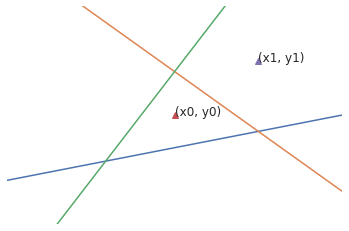

In [6]:
graph(["0.3*x + 4", "-1.1*x + 25", '2*x - 6'], range(21), points=[(10, 10), (15, 15)])

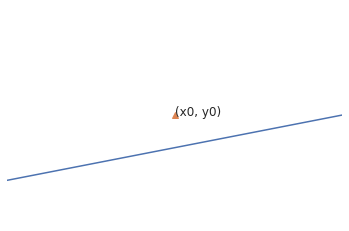

In [7]:
graph(["0.3*x + 4"], range(21), points=[(10, 10)])

## Experimental results

Next, we will go through some experimental results. We have benchmarked our GLN implementations on MNIST (more precisely, a [deskewed version](https://fsix.github.io/mnist/)), compared performance to a standard multi-layer perceptron (MLP), and performed detailed ablation experiments. We plan to add results for some of the other datasets and experiments of the original GLN paper (UCI dataset, MNIST density modeling, resilience to catastrophic forgetting) in the future.

### Setup and hyperparameters

First, note that GLNs predict a binary output, so the 10-class MNIST classification task is modeled as 10 1-vs-all binary classifiers. Furthermore, we follow the paper in using the appropriately re-scaled image as base prediction input. Based on preliminary investigations, we chose a 16-16-1 architecture per class and otherwise use the [default hyperparameters in the repo](https://github.com/aiwabdn/pygln/blob/master/pygln/gln.py), apart from the target hyperparameter in ablation experiments. Unless explicitly specified, the PyTorch GLN implementation is used in all experiments. For the MLP baseline, also implemented in PyTorch, we chose a 64-10 architecture with tanh activation function and a learning rate of $2.5 \cdot 10^{-4}$. Unless specified otherwise, the results are obtained after training for 1 epoch, and we use a batch size of 1 for both the GLN and the MLP baseline. Moreover, results are averaged over 10 runs, and in plots the shaded area indicates minimum and maximum performance across these 10 runs.

### Overall performance for different backends

We observe an accuracy of $96.1\%$ after a single pass over the training data, consistently across backends and on par with the MLP baseline. While this result is based on different hyperparameters, we weren't able to find hyperparameters to replicate the $98\%$ accuracy reported in the paper. In terms of runtime, JAX is more than twice as fast, and PyTorch around 7 times as fast as the NumPy implementation. However, the PyTorch version still takes almost twice as long as the MLP baseline.

**TENSORFLOW RUNTIME !!!**

| Backend       | Accuracy | Runtime |
|---------------|----------|---------|
| JAX           | 96.1%    | 257 sec |
| NumPy         | 96.1%    | 570 sec |
| PyTorch       | 96.1%    | 85 sec  |
| TensorFlow    | 96.1%    | 339 sec |
| MLP (PyTorch) | 96.1%    | 48 sec  |

### Performance during training

![ablation-epoch](results/epoch.png)

### Ablation: architecture size and depth

![ablation-size](results/size.png)
![ablation-depth](results/depth.png)